<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/DuckDB_in_Jupyter_Notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DuckDB in Jupyter Notebooks
A streamlined workflow for SQL analysis with DuckDB and Jupyter

## Library Import and Configuration

In [1]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install -q osmnx
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 291.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.5 MB/s eta 0:00:00


In [2]:
import duckdb
import pandas as pd
import geopandas as gpd
import shapely
import osmnx as ox
import pydeck as pdk
# No need to import sqlalchemy or duckdb_engine
#  JupySQL will use SQLAlchemy to auto-detect the driver needed based on your connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


We configure jupysql to return data as a Pandas dataframe and have less verbose output

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

## Connecting to DuckDB
Connect jupysql to DuckDB using a SQLAlchemy-style connection string. You may either connect to an in memory DuckDB, or a file backed db.

In [5]:
%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [6]:
%%sql
INSTALL httpfs;
INSTALL spatial;

,Success


## Downloading Builings in small area

In [7]:
W,S,E,N =  72.824548,19.19574,72.869386,19.231531

In [8]:
%%time

%%sql
LOAD spatial;
LOAD httpfs;

COPY (
    SELECT
        id,
        level,
        height,
        ST_GeomFromWkb(geometry) AS geometry
    FROM read_parquet('s3://overturemaps-us-west-2/release/2024-06-13-beta.0/theme=buildings/type=*/*', filename=true, hive_partitioning=1)
    WHERE
        bbox.xmin > 72.824548
        AND bbox.xmax < 72.869386
        AND bbox.ymin > 19.19574
        AND bbox.ymax < 19.231531
) TO 'buildings_mumbai.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 3min 7s, sys: 2.04 s, total: 3min 9s
Wall time: 3min 11s


,Success


In [30]:
%%sql
LOAD spatial;
LOAD httpfs;

COPY (
    SELECT
        id,
        ST_GeomFromWkb(geometry) AS geometry
    FROM read_parquet('s3://overturemaps-us-west-2/release/2024-06-13-beta.0/theme=transportation/type=*/*', filename=true, hive_partitioning=1)
    WHERE
        bbox.xmin > 72.824548
        AND bbox.xmax < 72.869386
        AND bbox.ymin > 19.19574
        AND bbox.ymax < 19.231531
) TO 'transportation_mumbai.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


In [15]:
def create_map(W,S,E,N, geojson_file=None):
    bbox_geom = shapely.geometry.box(W,S,E,N)
    boundary_json = eval(gpd.GeoSeries(bbox_geom).to_json())

    boundary_layer = pdk.Layer(
        "GeoJsonLayer",
        boundary_json,
        opacity=1,
        stroked=True,
        filled=False,
        get_line_color=[100, 0, 0]
    )
    if geojson_file is not None:
        layer = pdk.Layer(
            "GeoJsonLayer",
            geojson_file,
            opacity=1,
            stroked=True,
            filled=True,
            get_fill_color=[100, 200, 0],
            get_line_color=[0,100,0],
            pickable=True
        )
        layers = [boundary_layer, layer]
    else:
        layers = [boundary_layer]


    C = bbox_geom.centroid
    view_state = pdk.ViewState(latitude=C.y, longitude=C.x, zoom=11, bearing=0, pitch=45)
    # Render

    r = pdk.Deck(layers=layers, initial_view_state=view_state, tooltip = True)
    return r

In [24]:
trans_gdf = gpd.read_file("transportation_mumbai.geojson")
trans_gdf["geom_type"] = trans_gdf["geometry"].apply(lambda x:x.geom_type)
trans_gdf_lines = trans_gdf[trans_gdf["geom_type"]=='Point']
trans_gdf_lines.shape

(4062, 3)

CPU times: user 296 ms, sys: 66.8 ms, total: 362 ms
Wall time: 298 ms


<Axes: >

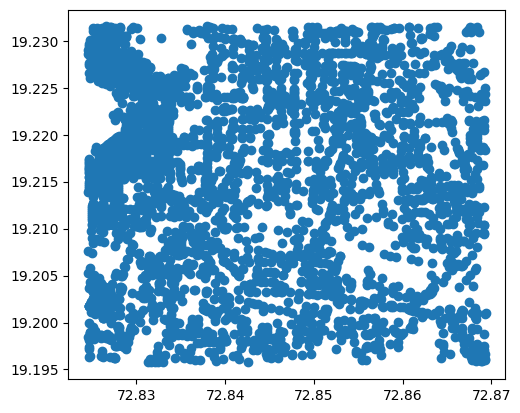

In [27]:

%%time
#ax = gpd.read_file("buildings_mumbai.geojson").plot(color='red')
trans_gdf_lines.plot()

In [47]:
%%time
buildings_gdf = gpd.read_file("buildings_mumbai.geojson").fillna("Na")
print(buildings_gdf.shape[0])
buildings_gdf = buildings_gdf.sample(1000)
geojson = eval(buildings_gdf.to_json())

30495
CPU times: user 7.82 s, sys: 140 ms, total: 7.96 s
Wall time: 7.95 s


In [48]:
Map = create_map(W,S,E,N, geojson_file=geojson)
Map

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 19.213635500000002,
    "longitude": 72.846967,
    "pitch": 45,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "bbox": [
          72.824548,
          19.19574,
          72.869386,
          19.231531
        ],
        "features": [
          {
            "bbox": [
              72.824548,
              19.19574,
              72.869386,
              19.231531
            ],
            "geometry": {
              "coordinates": [
                [
                  [
                    72.869386,
                    19.19574
                  ],
                  [
                    72.869386,
                    19.231531
                  ],
                  [
                    72.824548,
                    19.231531
                  ],
                  [
                    72.824548,
                    19.19574
                  ],
                  [
                    72.869386,
                    19.19574
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "0",
            "properties": {},
            "type": "Feature"
          }
        ],
        "type": "FeatureCollection"
      },
      "filled": false,
      "getLineColor": [
        100,
        0,
        0
      ],
      "id": "d967f6cb-ac19-470c-abb1-e9a2d3953162",
      "opacity": 1,
      "stroked": true
    },
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "features": [
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    72.85235266987115,
                    19.200324908293496
                  ],
                  [
                    72.85244107665945,
                    19.200327800728587
                  ],
                  [
                    72.85244024134894,
                    19.20035057048578
                  ],
                  [
                    72.85235183456065,
                    19.200347678051088
                  ],
                  [
                    72.85235266987115,
                    19.200324908293496
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "3939",
            "properties": {
              "height": "Na",
              "id": "08b608b444c26fff02007f3dcbf5eb34",
              "level": "Na"
            },
            "type": "Feature"
          },
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    72.8277031,
                    19.2305108
                  ],
                  [
                    72.8276886,
                    19.2304359
                  ],
                  [
                    72.8276684,
                    19.2304393
                  ],
                  [
                    72.827651,
                    19.2303492
                  ],
                  [
                    72.8277545,
                    19.2303313
                  ],
                  [
                    72.8277516,
                    19.2303161
                  ],
                  [
                    72.8278071,
                    19.2303065
                  ],
                  [
                    72.8278243,
                    19.2303951
                  ],
                  [
                    72.827782,
                    19.2304024
                  ],
                  [
                    72.8277921,
                    19.2304544
                  ],
                  [
                    72.8277667,
                    19.2304588
                  ],
                  [
                    72.8277744,
                    19.2304985
                  ],
                  [
                    72.8277031,
                    19.2305108
                  ]
  

In [ ]:
Map

<IPython.core.display.Javascript object>